<a href="https://colab.research.google.com/github/daa103/DAA_ESAA/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8_7%EC%9E%A5_%EC%95%99%EC%83%81%EB%B8%94_%ED%95%99%EC%8A%B5%EA%B3%BC_%EB%9E%9C%EB%8D%A4_%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8_%E2%80%8Bp_245_271.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**앙상블 학습과 랜던 포레스트**
- 앙상블: 여러 예측을 수집하여 예측하는 방법
- 랜덤포레스트: 결정트리의 앙상블

####**7.1 투표기반 분류기**
- 직접투표분류기: 각 분류기의 예측을 모아 다수결로 선택되는 분류기
--> 앙상블에 포함된 개별분류기중 뛰어난 것보다 정확도가 더 높을 수 있다. (큰수의 법칙 때)

In [ ]:
# 5장 moons dataset
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [ ]:
# 여러 분류기를 조합하여 투표기반 분류기를 만들고 훈련시키는 코드
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),('rf',rnd_clf),('svc',svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [ ]:
# 테스트 정확도 알아보기
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.95
RandomForestClassifier 0.95
SVC 0.95
VotingClassifier 1.0


- 예상대로 투표기반 분류기가 다른 개별 분류기보다 성능이 높다.
- 간접투표: 모든 분류기가 클래스 확률 예측이되면 개별분류기의 예측을 평균내 확률이 높은 클래스를 예측할 수 있다. (직접투표보다 성능 good)
- - voting='soft'
- - probability='True'로 설정

####**7.2 배깅과 페이스팅**
- 배깅: 훈련세트에서 중복을 허용하여 샘플링
- 페이스팅: 중복을 허용하지 않고 샘플링

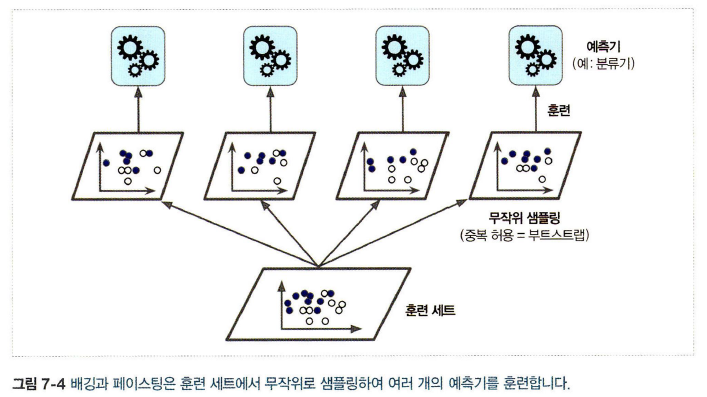

- 수집함수는 전형적으로 분류일때는 통계적 최빈값
- 일반적으로 앙상블 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어든다.
####**7.2.1 사이킷런의 배깅과 페이스팅**
- 페이스팅 사용시 bootstrap=False 로 지정
- n_jobs 매개변수는 사이킷런이 훈련과 예측에 사용할 CPU 코어수 지

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=50, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

- 단일결정트리의 결정경계와 500개의 트리를 사용한 배깅 앙상블을 비교해보면 앙상블 예측이 일반화가 잘되었다.
- 앙상블은 비슷한 편향에서 더 작은 분산을 만든다.

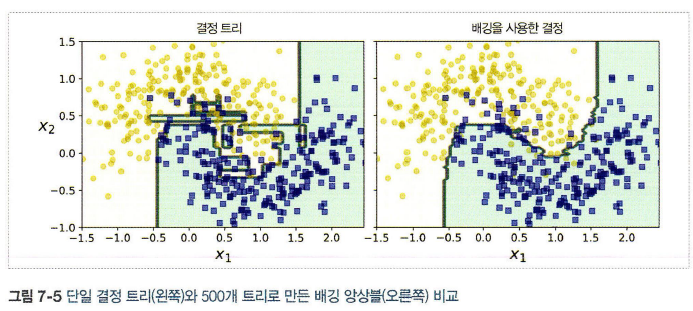

####**7.2.2oob평가**
- 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러번 샘플링되고 어떤 것은 선택되지 않는다.
- BaggingClassifier는 기본값으로 중복을 허용하여 훈련세트 크기만큼 m개의 샘플을 선택
- 앙상블평가는 각 예측기의 oob평가를 평균하여 얻는다.
- BaggingClassifier를 만들때 oob_score=True로 지정하면 훈련이 끝나고oob평가를 수행한다.

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9375

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.95

oob샘플에 대한 결정함수값도 oob_decision_function_ 변수에서 확인할 수 잏다.


In [ ]:
bag_clf.oob_decision_function_

array([[0.27428571, 0.72571429],
       [0.02312139, 0.97687861],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.7967033 , 0.2032967 ],
       [0.99481865, 0.00518135],
       [0.5       , 0.5       ],
       [0.90810811, 0.09189189],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.81621622, 0.18378378],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.63157895, 0.36842105],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.08045977, 0.91954023],
       [0.89759036, 0.10240964],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.11797753, 0.88202247],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.89005236, 0.10994764],
       [0.99453552, 0.00546448],
       [0.09852217, 0.90147783],
       [0.06217617, 0.93782383],
       [0.98850575, 0.01149425],
       [0.

####**7.3 랜덤패치와 랜덤서브스페이스**
- BaggingClassifier는 특성샘플링을 지원한다.
- 훈련특성과 샘플을 모두 샘플링하는 것을 랜덤패치방식이라고 한다.
- 훈련샘플을 모두 사용하고 특성은 샘플링하는 것을 랜덤 서브스페이스방식이라고 한다.

####**7.4 랜덤포레스트**
- 배깅방법을 적용한 결정트리의 앙상블
- max_samples를 훈련세트의 크기로 지정한다.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

랜덤포레스트는 무작위성을 주입하여 분산을 낮춘다.

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)


####**7.4.1 엑스트라 트리**
- 익스트림 랜덤트리: 극단적으로 무작위한 트리의 랜덤포레스트
- 일반적인 랜덤포레스트보다 빠르다.



####**7.4.2 특성중요도**
- 랜덤포레스트는 상대적 중요도를 측정하기 쉽다.
-사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 감소시키는지 확인하여 특성의 중요도를 측정한다.

In [ ]:
# RandomForestClassifier를 훈련시키고 특성의 중요도를 출력함
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.09681083061929718
sepal width (cm) 0.02446985398156262
petal length (cm) 0.44488031676423423
petal width (cm) 0.433838998634906


랜덤포레스트는 특성을 선택해야할때 어떤 특성이 중요한지 빠르게 확인할 수 있어 편리하다.

####**7.5 부스팅**
-약한 학습기를 여러개 연결하여 강한 학습기를 만드는 방법
- 앞의 모델을 보완해나가면서 예측기학습

####**7.5.1에이다부스트**
- 이전모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것.
- 알고리즘 기반이되는 첫번째 분류기를 훈련세트에서 훈련시키고 예측을 만든다.
- 잘못분류된 훈련샘플의 가중치를 상대적으로 높인다.
- 두번째 분류기는 가중치를 사용해 다시 예측을 만든다.
- 경사하강법과 비슷한 방식인데, 경사하강법은 비용함수를 최소화하기 위해 조정하는 반면 에이다부스트는 더 좋아지도록 앙상블에 예측기를 추가하는 것

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

####**7.5.2 그래디언트 부스팅**

- 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가한다.
- 잔여오차에 새로운 예측기를 학습시킨다.




In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

In [ ]:
y2 = y-tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2)

In [ ]:
#두번째 예측기가 만든 잔여오차에서 세번째 회귀를 훈련
y3 = y2-tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

In [ ]:
#세개의 트리를 포함하는 앙상블, 모든트리의 예측을 더해 새로운 샘플의 예측을 만든다
#y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

- learning_rate 매개변수가 각 트리의 기여정도를 조절
- 축소: 앙상블 훈련세트에 학습시키기위해 많은 트리가 필요하지만 예측성능은 좋아지는 것

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train,y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)+1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=31)

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1,120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up=0
  else:
    error_going_up += 1
    if error_going_up ==5:
      break

- GradientBoostingRegressor는 훈련에 사용할 훈련 샘풀 비율을 지정할 수 있다.
- 편향이 높아지는 대신 분산이 낮아지고 훈련속도를 높인다.

In [ ]:
# 그래디언트 부스팅 구현으로 XGBoost 라이브러리
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [ ]:
xgb_reg.fit(X_train, y_train, eval_set =[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.37411
[1]	validation_0-rmse:0.29286
[2]	validation_0-rmse:0.24403
[3]	validation_0-rmse:0.21733
[4]	validation_0-rmse:0.20465
[5]	validation_0-rmse:0.19910
[6]	validation_0-rmse:0.19713
[7]	validation_0-rmse:0.19680
[8]	validation_0-rmse:0.19712
[9]	validation_0-rmse:0.19767


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


####**7.6 스태킹**
- 앙상블에 속한 예측기의 예측을 취합하는 함수대신 취합하는 모델을 훈련시키는 방법
- 홀드아웃방식을 사용해 마지막 예측기인 블렌더를 학습시킨다.

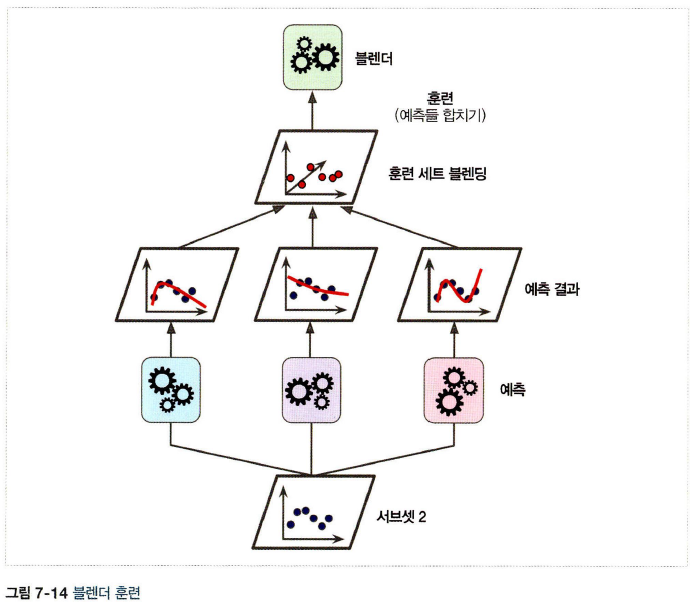
